[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/UNSW-COMP9418/Week10/blob/main/COMP9418_W10_Approximate_Inference_with_Sampling.ipynb)

# Approximate Inference with Sampling

**COMP9418 W10 Tutorial**

- Instructor: Gustavo Batista
- School of Computer Science and Engineering, UNSW Sydney
- Notebook designed by Gustavo Batista
- Last Update 6th September 2022

In this week's tutorial, we will implement the four sampling algorithms discussed in the lecture. We will also investigate the performance of these algorithms in terms of running time and accuracy for answering marginal and conditional probabilistic queries.

## Technical prerequisites

You will need certain packages installed to run this notebook.

If you are using ``conda``'s default [full installation](https://conda.io/docs/install/full.html), these requirements should all be satisfied already.

If you are using ``virtualenv`` or other native package management, you may need to run this command:

```python
pip3 install matplotlib
```

To render a visualization of some graphical models, you also need to install Graphviz [download page](http://www.graphviz.org/download). We have already used this library in Tutorial 1, thus, you should have it installed.

Once we have done all that, we import some useful modules for later use.

In [1]:
# visualise plots
import matplotlib.pyplot as plt
# random number generator library
import random
# access to math.inf
import math
# ndarrays
import numpy as np
# library to check if a file exists
import os.path

In [3]:
# Only run this cell if you do not want to use your libraries and
# prefer to download our implementation from GitHub

#if not (os.path.exists("DiscreteFactors.py")):
#    !wget 'https://raw.githubusercontent.com/UNSW-COMP9418/libraries/main/DiscreteFactors.py'
#if not os.path.exists("Graph.py"):
#    !wget 'https://raw.githubusercontent.com/UNSW-COMP9418/libraries/main/Graph.py'
if not os.path.exists("BayesNet_VE.py"):
    !wget 'https://raw.githubusercontent.com/UNSW-COMP9418/libraries/main/BayesNet_VE.py'

--2022-11-14 16:52:11--  https://raw.githubusercontent.com/UNSW-COMP9418/libraries/main/BayesNet_VE.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9319 (9.1K) [text/plain]
Saving to: ‘BayesNet_VE.py’

BayesNet_VE.py      100%[===================>]   9.10K  --.-KB/s    in 0.007s  

2022-11-14 16:52:15 (1.24 MB/s) - ‘BayesNet_VE.py’ saved [9319/9319]



In [12]:
from DiscreteFactors import Factor
from Graph import Graph
from BayesNet_VE import BayesNet

# Sample a Bayesian network variable

First, we will develop a simple function to sample one variable $X$ according to $P(X|\textbf{u})$, with $\textbf{u}$ being a complete assignment for the variables $\textbf{U}$ that are the parents of $X$.

## Exercise

Let's extend the `Factor` class by implementing the function `sample_variable` that samples a variable $X$ according to $P(X|\textbf{u})$. The function will assume that the factor is appropriately normalized with $X$ as the child variable.

In [6]:
class Factor(Factor):
    def sample_variable(self, var, **evi):
        '''
        This function assumes that all domain variables are in `evi` except for `var`.
        The factor must also be appropriately normalized.
        `var`: variable to be sampled according to P(var|parents(var))
        `evi`: dict of assignments of parent variables
        return: value sampled according to P(var|parents(var))
        '''
        # Sample a value in the interval [0,1) using random()
        r = random.random()
        # s has the accumulative probabilities of P(var|parents(var))
        s = 0
        # select the appropriate row from the table
        indicies = tuple(slice(None) if v==var else self.outcomeSpace[v].index(evi[v]) for v in self.domain)
        # t will be the normalized vector of probs we are sampling from
        t = self.table[indicies]
        for i,outcome in enumerate(self.outcomeSpace[var]):
            s += t[i]
            # If we have achived a s value higher than s so v is the sampled value. 
            if r < s:
                return outcome

## The ICU network

Once again, we will use the ICU-Alarm network as a benchmark. You should remember this Bayesian Network from Week 3 Tutorial. It is a subset of nine nodes from a [larger network](https://www.bnlearn.com/bnrepository/discrete-medium.html#alarm) of 37 nodes.

The following image is a graphical representation of a subset of nine nodes we will use in this tutorial.

![ICU Graph](https://raw.githubusercontent.com/UNSW-COMP9418/Week10/main/img/ICU_graph.png "Graph exercise")

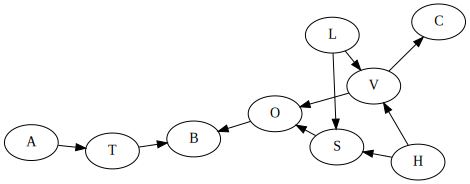

In [7]:

# define Bayes Net Graph
graph = Graph({
    'L': ['S', 'V'],
    'H': ['S', 'V'],
    'S': ['O'],
    'V': ['C', 'O'],
    'O': ['B'],
    'A': ['T'],
    'T': ['B'],
    'C': [],
    'B': [],
})
# Define outcome space of each random variable
outcomeSpace = dict(
    H=(0,1),
    L=(0,1),
    A=(0,1),
    V=(0,1),
    S=(0,1),
    T=(0,1),
    C=(0,1,2),
    O=(0,1,2),
    B=(0,1,2),
)
# Initialize Bayesian Network object
ICU_Net = BayesNet(graph, outcomeSpace)

# Add each factor one by one to the ICU_Net object
h = Factor(('H',), outcomeSpace)
h[0] = 0.8
h[1] = 0.2
ICU_Net.factors['H'] = h

v = Factor(('L', 'H', 'V'), outcomeSpace)
v[0, 0, 0] = 0.05
v[0, 0, 1] = 0.95
v[0, 1, 0] = 0.99
v[0, 1, 1] = 0.01
v[1, 0, 0] = 0.1
v[1, 0, 1] = 0.9
v[1, 1, 0] = 0.9
v[1, 1, 1] = 0.1
ICU_Net.factors['V'] = v

c = Factor(('V', 'C'), outcomeSpace)
c[0, 0] = 0.94
c[0, 1] = 0.04
c[0, 2] = 0.02
c[1, 0] = 0.02
c[1, 1] = 0.26
c[1, 2] = 0.72
ICU_Net.factors['C'] = c

l = Factor(('L',), outcomeSpace)
l[0] = 0.95
l[1] = 0.05
ICU_Net.factors['L'] = l

s = Factor(('L','H','S'), outcomeSpace)
s[0, 0, 0] = 0.04
s[0, 0, 1] = 0.96
s[0, 1, 0] = 0.48
s[0, 1, 1] = 0.52
s[1, 0, 0] = 0.95
s[1, 0, 1] = 0.05
s[1, 1, 0] = 0.1
s[1, 1, 1] = 0.9
ICU_Net.factors['S'] = s

o = Factor(('S', 'V', 'O'), outcomeSpace)
o[0, 0, 0] = 0.97
o[0, 0, 1] = 0.01
o[0, 0, 2] = 0.02
o[0, 1, 0] = 0.78
o[0, 1, 1] = 0.19
o[0, 1, 2] = 0.03
o[1, 0, 0] = 0.22
o[1, 0, 1] = 0.76
o[1, 0, 2] = 0.02
o[1, 1, 0] = 0.01
o[1, 1, 1] = 0.01
o[1, 1, 2] = 0.98  
ICU_Net.factors['O'] = o

t = Factor(('A','T'), outcomeSpace)
t[0, 0] = 0.30
t[0, 1] = 0.70
t[1, 0] = 0.9
t[1, 1] = 0.1
ICU_Net.factors['T'] = t

b = Factor(('O', 'T', 'B'), outcomeSpace)
b[0, 0, 0] = 0.9
b[0, 0, 1] = 0.05
b[0, 0, 2] = 0.05
b[0, 1, 0] = 0.30
b[0, 1, 1] = 0.62
b[0, 1, 2] = 0.08
b[1, 0, 0] = 0.93
b[1, 0, 1] = 0.06
b[1, 0, 2] = 0.01
b[1, 1, 0] = 0.02
b[1, 1, 1] = 0.49
b[1, 1, 2] = 0.49
b[2, 0, 0] = 0.90
b[2, 0, 1] = 0.08
b[2, 0, 2] = 0.02
b[2, 1, 0] = 0.01
b[2, 1, 1] = 0.08
b[2, 1, 2] = 0.91 
ICU_Net.factors['B'] = b

a = Factor(('A',), outcomeSpace)
a[0] = 0.99
a[1] = 0.01
ICU_Net.factors['A'] = a

ICU_Net.graph.show()



For now on, we will use the same notation as the lecture slides. In particular, the variable sigma ($\Sigma$) represents the assignment being sampled (variable by variable) from the Bayesian network. Each time we sample a value $x$ to a variable $X$, we add the entry `X:x` to the dictionary sigma.

Here is a test to confirm the `sample_variable` function is implemented correctly.

In [8]:
#################
# Test code

random.seed(0)

sigma = {'A': 0}
zero = 0
one = 0
f = ICU_Net.factors['T']
for i in range(1000):
    sample = f.sample_variable('T', **sigma)
    if sample == 0:
        zero += 1
    else:
        one += 1
print("P(T=0|A=0)=",zero/(one+zero))
print("P(T=1|A=0)=",one/(one+zero))

P(T=0|A=0)= 0.296
P(T=1|A=0)= 0.704


If your code is correct, you should see (approximately) the following output:

```
P(T=0|A=0)= 0.296
P(T=1|A=0)= 0.704
```

Compare these numbers obtained with 1000 samples with the true probabilities in the factor $P(T|A)$.


# Simulate a Bayesian network

Let's implement a procedure that simulates the Bayesian network. The simulation is the process that visits the network nodes in topological order and samples each node. At the end of the simulation, we will have a complete instantiation of the network variables.

## Exercise

Let's implement the function `simulate`. We will need the `<Graph>.topological_sort` and `<Factor>.sample_variable` functions implemented before.

In [13]:
class BayesNet(BayesNet):
    def simulate(self):
        # Compute the topological order of G (since this function is called many times, we could alternatively precompute this order in __init__)
        order = self.graph.topological_sort()
        # Initialize `sigma` with an empty dictionary
        sigma = {}
        # Let's iterate over all variables according to the order
        for var in order:
            # Call `sample_variable` to sample variable `var`, modifying the `sigma` assignment
            sigma[var] = self.factors[var].sample_variable(var, **sigma)
        return sigma

####################
# Test code

random.seed(0)
ICU_Net = BayesNet(ICU_Net.graph, ICU_Net.outcomeSpace, ICU_Net.factors)
print(ICU_Net.simulate())


{'A': 0, 'T': 1, 'H': 0, 'L': 0, 'V': 1, 'C': 2, 'S': 1, 'O': 2, 'B': 2}


If your code is correct, you should see the following output:

```
{'A': 0, 'T': 1, 'H': 0, 'L': 0, 'V': 1, 'C': 2, 'S': 1, 'O': 2, 'B': 2}
```

This is one complete assignment sampled according to the underlying probability distribution specified by the Bayesian network. 

Let's now implement forward sampling to compute answers to prior marginal queries.

# Forward sampling

Forward sampling is a straightforward sampling procedure to compute prior marginal queries. Prior marginal queries are queries that do not involve evidence. Therefore, they are in the form $P(\alpha)$ where $alpha$ is an assignment to one or more variables.

In our implementation, we will specify a dictionary `alpha` that maps variables to values. For instance, if `alpha = {'A': 0})`, it means we want to compute $P(A=0)$. Similarly, if `alpha = {'A': 0, 'B': 1})`, we want to know $P(A=0,B=1)$. In addition, we will need to specify `n_samples` that is the number of samples used to estimate the probabilities.

## Exercise

Complete the implementation of `forward_sampling` function. 

In [15]:
class BayesNet(BayesNet):
    def forward_sampling(self, n_samples, alpha):
        '''
        This function answers queries like: What is the probability that B=1? Or B=1 and T=0?
        `n_samples`: number of samples used to compute the probabilities
        `alpha`: The query vars, a dictionary mapping variables to values
        return: P(alpha)
        '''
        # Initialise count. The variable counts the number of samples that agree with alpha 
        count = 0
        for i in range(n_samples):
            # Call simulate to obtain a new assigment according to P(X)
            sample = self.simulate()
            # Let's test if alpha matches s. If it does, increment the count p
            if (all(v == sample[k] for k, v in alpha.items())):
                count += 1
        return count/n_samples

random.seed(0)
ICU_Net = BayesNet(ICU_Net.graph, ICU_Net.outcomeSpace, ICU_Net.factors)

p = ICU_Net.forward_sampling(1000, {'A':0})
print("P(A=0)=", p)
p = ICU_Net.forward_sampling(1000, {'B':1, 'A':0})
print("P(B=1,A=0)=", p)


P(A=0)= 0.993
P(B=1,A=0)= 0.183


If your code is correct, you should see the following output (approximately):

```
P(A=0)= 0.993
P(B=1,A=0)= 0.183
```

## Benchmarking with random queries

To benchmark our code, we need a large set of queries. As the forward sampling can only compute prior marginals, our queries need to be the form $P(\textbf{Q=q})$ where $\textbf{Q}$ are the query variables and $\textbf{q}$ are the corresponding values.

Next, we create a procedure that will create a set of random queries. We will use these queries to compare the sampling estimates to the true probabilities obtained with variable elimination.

First, let's take a look at a helper function that creates a random assignment with a maximum number of variables specified by `n_vars`.

In [16]:
# This is a helper function that creates an assignment (dictionary) with at most n_vars variables
def random_assignment(outcomeSpace, n_vars, exclude = []):
    """
    argument
    `outcomeSpace`: dictionary with variables names and corresponding valid values
    `n_vars`: maximum number of variables in the assignment
    `exclude`: list of variables names that cannot be included in the assignment
    return: dictionary representing an assignment with variables as keys and their corresponding values
    """    
    all_vars = [v for v in outcomeSpace.keys() if v not in exclude]
    rvars = random.sample(all_vars, random.randint(1, n_vars))
    return { v : random.choice(outcomeSpace[v]) for v in rvars}

################
# Test code

random.seed(0)
print(random_assignment(outcomeSpace, 5))
print(random_assignment(outcomeSpace, 3))
print(random_assignment(outcomeSpace, 1))

{'C': 1, 'H': 1, 'A': 1, 'S': 1}
{'V': 1, 'A': 0}
{'S': 0}


Now, we will implement a function that answers the queries created by `random_assignment`. We will use the variable elimination algorithm.

## Exercise 

Implement the `query_generator_prior_marginal`. This function calls `random_assignment` to create prior marginal queries and answers those queries with the VE algorithm. The argument `n_queries` specifies the number of queries to be created and answered.

In [25]:
def query_generator_prior_marginal(n_queries, bayesNet):
    """
    argument
    `n_queries`: number of queries to be created and answered
    `factors`: a dictionary will all netowrk factors
    `outcomeSpace`: dictionary with variables names and corresponding valid values
    return: list of dictionaries with the query and associated probability exactly computed with the VE algorithm
    """
    # query_list starts as an empty list
    query_list = []
    for i in range(n_queries):
        # Assign to alpha a random assignment created by `random_assignment`
        alpha = random_assignment(bayesNet.outcomeSpace, 3)
        # Compute the answer to alpha using the VE query function from week 4
        keys = list(alpha.keys())
        f = bayesNet.query(list(alpha.keys()))
        # Prepare the entries to compute the probability
        entry = tuple(alpha[v] for v in f.domain)
        # Store the results in query_list
        query_list.append({'query': alpha, 'prob': f[entry]})
    return query_list


################
# Test code

random.seed(0)
results = query_generator_prior_marginal(10, ICU_Net)
for r in results:
    print("P(",r['query'],") =",r['prob'])

P( {'C': 1, 'H': 1} ) = 0.008637999999999998
P( {'S': 1, 'O': 2} ) = 0.6857236800000001
P( {'B': 0} ) = 0.3210289226056
P( {'A': 1, 'L': 0} ) = 0.009500000000000001
P( {'L': 1, 'B': 1} ) = 0.01971616586
P( {'L': 1, 'T': 0, 'V': 1} ) = 0.011322000000000004
P( {'B': 0, 'S': 0} ) = 0.07445750776239998
P( {'C': 2} ) = 0.55263
P( {'H': 1, 'O': 0, 'C': 2} ) = 0.0028169927999999998
P( {'L': 0, 'V': 0} ) = 0.22609999999999997


If your code is correct, you should see the following output:

```
P( {'C': 1, 'H': 1} ) = 0.008638
P( {'S': 1, 'O': 2} ) = 0.6857236800000002
P( {'B': 0} ) = 0.3210289226056
P( {'A': 1, 'L': 0} ) = 0.009500000000000001
P( {'L': 1, 'B': 1} ) = 0.01971616586
P( {'L': 1, 'T': 0, 'V': 1} ) = 0.011322000000000004
P( {'B': 0, 'S': 0} ) = 0.07445750776239998
P( {'C': 2} ) = 0.5526300000000001
P( {'H': 1, 'O': 0, 'C': 2} ) = 0.0028169927999999998
P( {'L': 0, 'V': 0} ) = 0.22609999999999997
```

Now, we will use the developed functions to create 300 queries and answer them with VE and forward sampling. We will use a scatter plot to compare the results. We have developed some code in the next cell to do this task. (May take ~ 30 seconds).

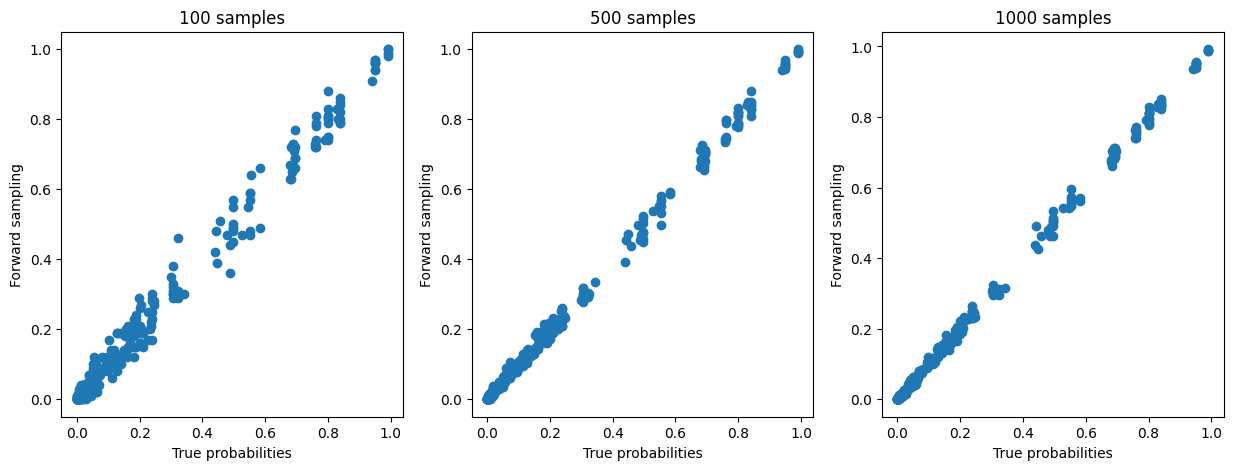

In [26]:
random.seed(0)
queries = query_generator_prior_marginal(300, ICU_Net)
x = [q['prob'] for q in queries]
y_100 = [ICU_Net.forward_sampling(100, q['query']) for q in queries]
plt.figure(figsize=(15, 5))
plt.subplot(1,3,1)
plt.scatter(x, y_100)
plt.title("100 samples")
plt.xlabel("True probabilities")
plt.ylabel("Forward sampling")
y_500 = [ICU_Net.forward_sampling(500, q['query']) for q in queries]
plt.subplot(1,3,2)
plt.scatter(x, y_500)
plt.title("500 samples")    
plt.xlabel("True probabilities")
plt.ylabel("Forward sampling")
y_1000 = [ICU_Net.forward_sampling(1000, q['query']) for q in queries]
plt.subplot(1,3,3)
plt.scatter(x, y_1000)
plt.title("1000 samples")    
plt.xlabel("True probabilities")
plt.ylabel("Forward sampling")    
plt.show()

Great, we can see that forward sampling works quite well for unconditional queries. Let's take a look at the relative errors.

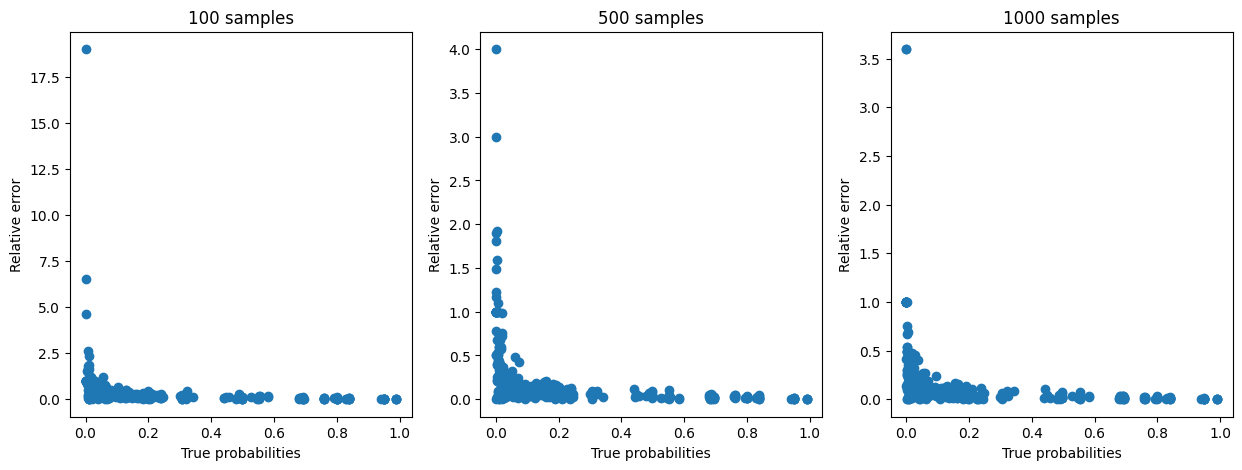

In [27]:
random.seed(0)
#queries = query_generator_prior_marginal(300, ICU_Net)
x = [q['prob'] for q in queries]
#y_100 = [ICU_Net.forward_sampling(100, q['query']) for q in queries]
relative_error = [abs(x[i]-y_100[i])/x[i] for i in range(len(x)) if x[i] != 0]
probs = [p for p in x if p != 0]
plt.figure(figsize=(15, 5))
plt.subplot(1,3,1)
plt.scatter(probs, relative_error)
plt.title("100 samples")
plt.xlabel("True probabilities")
plt.ylabel("Relative error")
#y = [ICU_Net.forward_sampling(500, q['query']) for q in queries]
relative_error = [abs(x[i]-y_500[i])/x[i] for i in range(len(x)) if x[i] != 0]
plt.subplot(1,3,2)
plt.scatter(probs, relative_error)
plt.title("500 samples")    
plt.xlabel("True probabilities")
plt.ylabel("Relative error")
#y = [ICU_Net.forward_sampling(1000, q['query']) for q in queries]
relative_error = [abs(x[i]-y_1000[i])/x[i] for i in range(len(x)) if x[i] != 0]
plt.subplot(1,3,3)
plt.scatter(probs, relative_error)
plt.title("1000 samples")    
plt.xlabel("True probabilities")
plt.ylabel("Relative error")
plt.show()

As we expected, the relative errors tend to be high for small probabilities, indicating that it is challenging to be relatively accurate in rare events. 

# Rejection sampling

Forward sampling is restricted to unconditional queries ($P(\textbf{Q})$). If we want to compute posterior marginals, we can make a straightforward adaptation. We reject all samples that do not match the evidence. This procedure is called rejection sampling.

The main difference between rejection and forward sampling is the simulation of the Bayesian network. With rejection sampling, we typically abort the simulation if we sample a value $x$ for an evidence variable $X \in \textbf{E}$ that do conform with the evidence $\textbf{e}$.

## Exercise

Let's start by implementing a function to simulate the network according to rejection sampling. The function `simulate_BN_rejection` has an argument `beta` that represents an assignment with the evidence. `beta` is a dictionary with the same format as `alpha`. Our objective will be to answer queries in the format $P(\alpha|\beta)$

In [29]:
class BayesNet(BayesNet):
    def simulate_rejection(self, beta):
        '''
        This procedure samples all variables in the Bayesian network. If we sample a value for a variable in beta and
        the sampled value does not match the assignment beta then we abort the simulation and return None
        '''
        # Compute the topological order of G (since this function is called many times, we could alternatively precompute this order in __init__)
        order = self.graph.topological_sort()
        # Initialize `sigma` with an empty dictionary
        sigma = {}
        # Let's iterate over all variables according to the order
        for var in order:
            # Call `sample_variable` to sample variable `var`, modifying the `sigma` assignment
            sigma[var] = self.factors[var].sample_variable(var, **sigma)
            # Test if the sampled value matches beta, if it does not abort and return None
            if var in beta.keys() and sigma[var] != beta[var]:
                return None
        return sigma

####################
# Test code

random.seed(0)
ICU_Net = BayesNet(ICU_Net.graph, ICU_Net.outcomeSpace, ICU_Net.factors)
print(ICU_Net.simulate_rejection({'A':0}))

{'A': 0, 'T': 1, 'H': 0, 'L': 0, 'V': 1, 'C': 2, 'S': 1, 'O': 2, 'B': 2}


If your code is correct, you should see the following output:

```
{'A': 0, 'T': 1, 'H': 0, 'L': 0, 'V': 1, 'C': 2, 'S': 1, 'O': 2, 'B': 2}
```

## Exercise

Let's complete the implementation of rejection sampling. The function `rejection_sampling` is very similar to `forward_sampling`. It will take `alpha` and `beta` assignments as input and return an estimate of $P(\alpha|\beta)$.

In [31]:
class BayesNet(BayesNet):
    def rejection_sampling(self, n_samples, alpha, beta):
        '''
        This function answers queries like: What is the probability that B=1? Or B=1 and T=0?
        `n_samples`: number of samples used to compute the probabilities
        `alpha`: The query vars, a dictionary mapping variables to values
        `beta`: a dictionary maping variables to values    
        return: P(alpha|beta)
        '''
        # Initialise count. The variable counts the number of samples that agree with alpha 
        count = 0
        # n stores the number of samples that match beta
        n = 0
        for i in range(n_samples):
            # Call simulate to obtain a new assigment according to P(X)
            sample = self.simulate_rejection(beta)
            if sample is not None:
                # Let's test if alpha matches s. If it does, increment the count p
                if (all(v == sample[k] for k, v in alpha.items())):
                    count += 1
                n += 1

        # If P(beta) is small than we may end up with no samples matching beta. We need to avoid a division by zero here
        # This line may be a problem when p(beta) = 0 and p(alpha|beta) is undefined
        if n == 0:
            return 0,0
        return count/n, n


random.seed(0)
ICU_Net = BayesNet(ICU_Net.graph, ICU_Net.outcomeSpace, ICU_Net.factors)

p,n = ICU_Net.rejection_sampling(1000, {'T':0}, {'A':0})
print("P(T=0|A=0)=", p, "computed with", n, "samples")

If your code is correct, you should see (approximately) the following output:

```
P(T=0|A=0)= 0.3021148036253776
```

Now, we can test the rejection sampling to see if it performs well for a large number of queries. We will create random queries as we did for the forward sampling.

## Exercise

Let's implement `query_generator_posterior_marginal` that will generate random queries with an alpha and beta parts.

In [ ]:
def query_generator_posterior_marginal(n_queries, bayesNet):
    """
    argument
    `n_queries`: number of queries to be created and answered
    `factors`: a dictionary will all netowrk factors
    return: list of dictionaries with the query and associated probability exactly computed with the VE algorithm
    """
    # query_list starts as an empty list
    query_list = []
    for i in range(n_queries):
        # Assign to alpha a random assignment created by `random_assignment`
        alpha = ... # TODO
        beta = ... # TODO
        # Compute the answer to alpha using VE query function
        f = ... # TODO
        # Prepare the entries to compute the probability
        entry = tuple(alpha[v] for v in f.domain)
        # Store the results in query_list
        query_list.append({'query': alpha, 'evidence': beta, 'prob': f[entry]})
    return query_list


################
# Test code

random.seed(0)
ICU_Net = BayesNet(ICU_Net.graph, ICU_Net.outcomeSpace, ICU_Net.factors)
results = query_generator_posterior_marginal(10, ICU_Net)
for r in results:
    print("P(",r['query']," | ",r['evidence'],") =",r['prob'])

If your code is correct, you should see the following output:

```
P( {'C': 1, 'H': 1}  |  {'B': 1, 'V': 1} ) = 0.0017515427949926759
P( {'V': 0, 'A': 0, 'O': 2}  |  {'C': 0, 'B': 1} ) = 0.0038999772774970264
P( {'L': 1}  |  {'A': 1, 'V': 1} ) = 0.048626626363516896
P( {'V': 1, 'O': 0, 'B': 2}  |  {'H': 1} ) = 0.00028619778399999993
P( {'H': 1, 'O': 0, 'C': 2}  |  {'B': 0, 'L': 0} ) = 0.004353998604346179
P( {'A': 1}  |  {'L': 1} ) = 0.01
P( {'O': 2, 'L': 1, 'A': 0}  |  {'S': 1, 'C': 1, 'V': 0} ) = 0.0011525190754039499
P( {'C': 0, 'T': 1, 'S': 0}  |  {'L': 0} ) = 0.0634793472
P( {'S': 0, 'O': 2, 'H': 0}  |  {'L': 0} ) = 0.000944
P( {'B': 2, 'C': 2, 'O': 1}  |  {'L': 1, 'T': 1, 'V': 1} ) = 0.06239792432432433
```

Now, we can assess the performance of rejection sampling using a set of random queries. We will use 300 queries in total. The next cell computes the queries and plots the results for VE and rejection sampling.

In [ ]:
random.seed(0)
queries = query_generator_posterior_marginal(300, ICU_Net)
x = [q['prob'] for q in queries]
r_100 = [ICU_Net.rejection_sampling(100, q['query'], q['evidence']) for q in queries]
y_100 = [r[0] for r in r_100]
plt.figure(figsize=(15, 5))
plt.subplot(1,3,1)
plt.scatter(x, y_100)
plt.title("100 samples")
plt.xlabel("True probabilities")
plt.ylabel("Rejection sampling")
r_500 = [ICU_Net.rejection_sampling(500, q['query'], q['evidence']) for q in queries]
y_500 = [r[0] for r in r_500]
plt.subplot(1,3,2)
plt.scatter(x, y_500)
plt.title("500 samples")    
plt.xlabel("True probabilities")
plt.ylabel("Rejection sampling")
r_1000 = [ICU_Net.rejection_sampling(1000, q['query'], q['evidence']) for q in queries]
y_1000 = [r[0] for r in r_1000]
plt.subplot(1,3,3)
plt.scatter(x, y_1000)
plt.title("1000 samples")    
plt.xlabel("True probabilities")
plt.ylabel("Rejection sampling")    
plt.show()

The results look much worse than the ones we obtained with forward sampling. This illustrates the issue we described in the lectures with the difficulty of sampling from distributions in the form $P(.|\beta)$. When $P(\beta)$ is small, we reject many samples, and we may end up with poor estimates.

Let's confirm this hypothesis. The next cell computes the same plot, but it associates the size of each point with the number of samples used to calculate the estimate.

In [ ]:
random.seed(0)
#queries = query_generator_posterior_marginal(300, ICU_Net)
x = [q['prob'] for q in queries]
#r_100 = [ICU_Net.rejection_sampling(100, q['query'], q['evidence']) for q in queries]
#y_100 = [x[0] for x in r_100]
w = [x[1]+.1 for x in r_100]                                   # Don't let the zero weight estimates disapper in the plot
plt.figure(figsize=(15, 5))
plt.subplot(1,3,1)
plt.scatter(x, y_100, s = w)
plt.title("100 samples")
plt.xlabel("True probabilities")
plt.ylabel("Rejection sampling")
#r_500 = [ICU_Net.rejection_sampling(500, q['query'], q['evidence']) for q in queries]
#y_500 = [x[0] for x in r_500]
w = [x[1]+.1 for x in r_500]                                   # Don't let the zero weight estimates disapper in the plot
plt.subplot(1,3,2)
plt.scatter(x, y_500, s = w)
plt.title("500 samples")    
plt.xlabel("True probabilities")
plt.ylabel("Rejection sampling")
#r_1000 = [ICU_Net.rejection_sampling(1000, q['query'], q['evidence']) for q in queries]
#y_1000 = [x[0] for x in r_1000]
w = [x[1]+.1 for x in r_1000]                                   # Don't let the zero weight estimates disapper in the plot
plt.subplot(1,3,3)
plt.scatter(x, y_1000, s = w)
plt.title("1000 samples")    
plt.xlabel("True probabilities")
plt.ylabel("Rejection sampling")    
plt.show()

Indeed, the poorest estimates are those associated with small sample sizes. Notice the several bad estimates returned zero probability, but the true probability was not zero. These are cases the probability of evidence was tiny, and we ended up with no samples.

# Likelihood weighting

Let's see if we can do better with likelihood weighting sampling. We need to start by creating a new procedure to simulate the Bayesian network and compute the weights.

The procedure is simple. We traverse the network in topological order. If the current node is an evidence variable, then we compute the weight associated with its likelihood. If the current node is not in the evidence set, we sample the variable related to the node.

## Exercise

Let's implement the function `simulate_BN_likelihood` that simulates the network and computes a sample and its corresponding weight.

In [ ]:
class BayesNet(BayesNet):
    def simulate_likelihood(self, beta):
        """
        `beta`:  a dictionary that represents an assignment for all evidence variables
        return: `sigma`, weight: a dictionary with a complete assigment with all network variables respecting beta and its corresponding weight
        """
        # Call topologicalSort to compute the order we will traverse the network
        order = ... # TODO
        # sigma is a complete assignment for all network variables. We start with an empty assignment
        sigma = {}
        # This is the assignment weight. We start with one and change it for each observed variable
        w = ... # TODO
        for var in order:
            if var not in beta.keys():
                # For the variables NOT in the evidence (beta), we need to sample a value for the variable
                sigma[var] = ... # TODO
            else:
                # For the variables in the evidence (beta), we need to update the weight
                sigma[var] = ... # TODO (use beta to get the value of this var)
                entry = tuple(sigma[v] for v in self.factors[var].domain)
                w *= self.factors[var][entry]

        return sigma, w
        

####################
# Test code

ICU_Net = BayesNet(ICU_Net.graph, ICU_Net.outcomeSpace, ICU_Net.factors)
random.seed(0)
print(ICU_Net.simulate_likelihood({'A':0}))

If your code is correct, you should see the following output:

```
({'A': 0, 'T': 1, 'H': 0, 'L': 0, 'V': 1, 'C': 2, 'S': 1, 'O': 2, 'B': 2}, 0.99)
```

Now, we can implement the `likelihood_weighting` function. This subroutine samples the network by simulating it according to the `simulate_BN_likelihood` procedure. It will be very similar to the code we have developed for the forward and rejection sampling.

## Exercise

Let's implement the `likelihood_weighting` function that creates `n_samples` samples and estimates the probability according to those samples.

Notice that the samples now have weights and we must consider them when we compute the probabilities.

In [ ]:
class BayesNet(BayesNet):
    def likelihood_weighting(self, n_samples, alpha, beta):
        '''
        This function answers queries like: What is the probability that B=1? Or B=1 and T=0?
        `n_samples`: number of samples used to compute the probabilities
        `alpha`: The query vars, a dictionary mapping variables to values
        `beta`: a dictionary maping variables to values    
        return: P(alpha|beta)
        '''
        # p stores the sum of weights of samples that match alpha and beta    
        p = 0
        # n stores the sum of weights of samples that match beta    
        n = 0
        for i in range(n_samples):
            # Call simulate_BN_likelihood to simulate the Bayesian network according to the likelihood weighting procedure        
            s, w = ... # TODO
            # Check if the sample matches alpha        
            if (all(v == s[k] for k, v in alpha.items())):
                p += w
            n += w
        # If P(beta) is small than we may end up with no samples matching beta. We need to avoid a division by zero here
        # This line may be a problem when p(beta) = 0 and p(alpha|beta) is undefined        
        if n == 0:
            return (0, 0)
        return p/n, n

#####################
# Test code

random.seed(0)
ICU_Net = BayesNet(ICU_Net.graph, ICU_Net.outcomeSpace, ICU_Net.factors)

p,w = ICU_Net.likelihood_weighting(1000, {'T':0}, {'A':0})
print("P(T=0|A=0)=", p, "computed with weight", w)

If your code is correct, you should see the following output:

```
P(A=0|T=0)= 0.2879999999999989 computed with weight 990.0000000000076
```

Now, we have all the tools we need to build several random queries and answer them with likelihood weighting. Let's see how this technique compares to rejection sampling.

In [ ]:
random.seed(0)
queries = query_generator_posterior_marginal(300, ICU_Net)
x = [q['prob'] for q in queries]
l_100 = [ICU_Net.likelihood_weighting(100, q['query'], q['evidence']) for q in queries]
y_100 = [l[0] for l in l_100]
plt.figure(figsize=(15, 5))
plt.subplot(1,3,1)
plt.scatter(x, y_100)
plt.title("100 samples")
plt.xlabel("True probabilities")
plt.ylabel("Likelihood weighting")
l_500 = [ICU_Net.likelihood_weighting(500, q['query'], q['evidence']) for q in queries]
y_500 = [l[0] for l in l_500]
plt.subplot(1,3,2)
plt.scatter(x, y_500)
plt.title("500 samples")    
plt.xlabel("True probabilities")
plt.ylabel("Likelihood weighting")
l_1000 = [ICU_Net.likelihood_weighting(1000, q['query'], q['evidence']) for q in queries]
y_1000 = [l[0] for l in l_1000]
plt.subplot(1,3,3)
plt.scatter(x, y_1000)
plt.title("1000 samples")    
plt.xlabel("True probabilities")
plt.ylabel("Likelihood weighting")    
plt.show()

Great! Likelihood weighting is a lot better than rejection sampling. That explains why this technique is so popular and used in several tasks such as robot mapping as we have seen in the lectures.

We can make a similar analysis we did with rejection sampling and check if the worst estimates are associated with small weights.

In [ ]:
random.seed(0)
#queries = query_generator_posterior_marginal(300, ICU_Net)
x = [q['prob'] for q in queries]
#l_100 = [ICU_Net.likelihood_weighting(100, q['query'], q['evidence']) for q in queries]
#y_100 = [x[0] for x in r_100]
w_100 = [x[1]+.1 for x in l_100]                                   # Don't let the zero weight estimates disapper in the plot
plt.figure(figsize=(15, 5))
plt.subplot(1,3,1)
plt.scatter(x, y_100, s = w_100)
plt.title("100 samples")
plt.xlabel("True probabilities")
plt.ylabel("Likelihood weighting")
#l_500 = [ICU_Net.likelihood_weighting(500, q['query'], q['evidence']) for q in queries]
#y_500 = [x[0] for x in l_500]
w_500 = [x[1]+.1 for x in l_500]                                   # Don't let the zero weight estimates disapper in the plot
plt.subplot(1,3,2)
plt.scatter(x, y_500, s = w_500)
plt.title("500 samples")    
plt.xlabel("True probabilities")
plt.ylabel("Likelihood weighting")
#l_1000 = [ICU_Net.likelihood_weighting(1000, q['query'], q['evidence']) for q in queries]
#y_1000 = [x[0] for x in l_1000]
w_1000 = [x[1]+.1 for x in l_1000]                                   # Don't let the zero weight estimates disapper in the plot
plt.subplot(1,3,3)
plt.scatter(x, y_1000, s = w_1000)
plt.title("1000 samples")    
plt.xlabel("True probabilities")
plt.ylabel("Likelihood weighting")    
plt.show()

# Gibbs sampling

Gibbs sampling is an algorithm based on Markov chains. The basic idea is that we can create a transition matrix that has as a stationary distribution the distribution induced by the Bayesian or Markov network. If we simulate this chain long enough, we can sample from the chain as if we were sampling from the underlying distribution induced by the network.

Gibbs sampling implementation is much more complex than the previous methods. To be an efficient method, we need to implement the inference for the transition matrix carefully.

In particular, such inference will involve a reduced number of factors. When sampling a variable $X$ we will need to have access to all factors that mention $X$.

We start by creating a graph that we call the *Gibbs graph*. In this graph, a node $X$ has a direct edge to all nodes $Y_i$ in which $X$ appears in the factor associated with $Y_i$.

## Exercise

Implement the `create_gibbs_graph` function that takes as input a set of factors and outputs a Gibbs graph.

In [ ]:
import copy
class BayesNet(BayesNet):
    def create_gibbs_graph(self):
        """
        argument 
        Returns an Graph object of the Gibbs graph
        """        
        # create a deepcopy of this network graph
        gg = ... # TODO
        for var in gg:
            ... # add an edge from this node to itself
        return gg


##############
# Test code

# List of positions for each node
# We use node positions to replicate the previous figure
# This can be removed if the nodes do not need to be presented in a specific order
pos = {
    'B': '1,0!',
    'O': '0,1!',
    'C': '1,1!',
    'T': '2,1!',
    'S': '0,2!',
    'V': '1,2!',
    'A': '2,2!',
    'L': '0,3!',
    'H': '1,3!',
}

ICU_Net = BayesNet(ICU_Net.graph, ICU_Net.outcomeSpace, ICU_Net.factors)
gg = ICU_Net.create_gibbs_graph()
gg.show(positions=pos)

If your output is correct, you should generate the following graph.

![Gibbs graph](https://raw.githubusercontent.com/UNSW-COMP9418/Week10/main/img/GG.png)

The Gibbs graph tells us that the factors that mention, for example, $H$ are in nodes $H$, $S$ and $V$. Therefore, we will need to multiply these factors to sample the variable $H$.

Before we implement the Gibbs transition, we need to remember that Markov chain Monte Carlo (MCMC) methods work with complete assignments. We will need a helper function that creates a complete assignment.

In [ ]:
class BayesNet(BayesNet):
    def complete_assignment(self, exclude = []):
        return { v : random.choice(outcomeSpace[v]) for v in outcomeSpace.keys() if v not in exclude}


#####################
# Test code

random.seed(0)
ICU_Net = BayesNet(ICU_Net.graph, ICU_Net.outcomeSpace, ICU_Net.factors)
alpha = ICU_Net.complete_assignment()
print(alpha)

Now, we will implement a `GibbsSampler` class with a `gibbs_transition` function. In some sense, it is similar to simulating the network. The main differences are:

1. We will work with complete assignments, instead of building one from scratch. 
2. There is no need to traverse the network in any specific order.
3. Each time we sample a variable, we will choose the variable randomly from the set of all non-evidence variables in the network.
4. The sampling process will involve an inference step. The previous sampling methods we discussed were more straightforward since we used conditional probabilities already available in the network parameters.

The main challenge is to implement the inference step efficiently. We will use the Gibbs graph to help us to identify the relevant factors correctly.

## Exercise

Implement the `__init__` and `gibbs_transition` function. The transition function takes the state as input, chooses one variable randomly with uniform distribution and samples a new value for this variable according to the Gibbs transition.

In [ ]:
class GibbsSampler():
    def __init__(self, bayesNet, beta):
        self.bayesNet = bayesNet
        self.beta = beta
        self.gibbs_graph = bayesNet.create_gibbs_graph()
        self.outcomeSpace = list(bayesNet.factors.values())[0].outcomeSpace

        # initialise state
        self.state = bayesNet.complete_assignment(beta)
        self.state.update(beta)


    def gibbs_transition(self):
        # These are the non-evidence variables in the network. We will sample from this list
        not_ev_vars = [v for v in self.outcomeSpace.keys() if v not in self.beta.keys()]
        # Randomly sample one variable with uniform distribution
        X = random.choice(not_ev_vars)
        # Create an empty factor that we will use to store our inference results
        gibbs_factor = Factor((X,), self.outcomeSpace)
        for value in self.outcomeSpace[X]:
            # Let's use the Gibbs graph to see which factors we need to multiply
            for var in self.gibbs_graph.children(X):
                # IMPORTANT: instead of call join and multiply all factors, we will only multiply the entries compatible with evidence
                # Remember we are working with complete assignments. See the lecture about classification with graphical models for details
                
                # Assign a value to variable X in the state
                self.state[X] = value
                # Compute the entry to retrieve the probability 
                entry = tuple(self.state[v] for v in self.bayesNet.factors[var].domain)
                # Multiply the probabilities in the relevant factors
                gibbs_factor[value] *= ... # TODO
        # Renormalize the gibbs_factor, so we probabilities sum to one and we can sample a value for X
        gibbs_factor = ... # TODO
        # Call sample_variable to sample a value for X according to the distribution in gibbs_factor
        self.state[X] = gibbs_factor.sample_variable(X)

        return self.state

    
##################
# Test code
random.seed(6)
# create a random query
beta = random_assignment(outcomeSpace, 3)
# initialize sampler
sampler = GibbsSampler(ICU_Net, beta)
print(sampler.state)
sampler.gibbs_transition()
print(sampler.state)

If your response is correct, you should see the following output:

```
{'H': 0, 'A': 1, 'V': 1, 'S': 1, 'T': 0, 'B': 1, 'L': 1, 'O': 0, 'C': 0}
{'H': 0, 'A': 1, 'V': 1, 'S': 0, 'T': 0, 'B': 1, 'L': 1, 'O': 0, 'C': 0}
```

## Exercise

Let's replace our current initialisation method with a slightly different way to initialise the chains. We can use the `simulate_likelihood` function to generate a sample that conforms with the evidence. 


In [ ]:
class GibbsSampler(GibbsSampler):
    def __init__(self, bayesNet, beta):
        self.bayesNet = bayesNet
        self.beta = beta
        self.gibbs_graph = bayesNet.create_gibbs_graph()
        self.outcomeSpace = list(bayesNet.factors.values())[0].outcomeSpace

        # Call simulate_likelihood to create initial assignment that agrees with beta
        w = 0
        # Let's discard assigments with zero weights. They may be invalid states if we have deterministic CPTs
        while(w==0):
            self.state, w = ... # TODO

        
################
# Test code

random.seed(0)
beta = random_assignment(outcomeSpace, 3)
for i in range(5):
    sampler = GibbsSampler(ICU_Net, beta)
    print(sampler.state)

If your code is correct, you should see the following output:

```
[{'A': 0, 'T': 1, 'H': 1, 'L': 0, 'V': 0, 'C': 1, 'S': 1, 'O': 1, 'B': 1},
 {'A': 0, 'T': 1, 'H': 1, 'L': 0, 'V': 0, 'C': 1, 'S': 1, 'O': 2, 'B': 2},
 {'A': 0, 'T': 1, 'H': 1, 'L': 0, 'V': 0, 'C': 1, 'S': 1, 'O': 1, 'B': 1},
 {'A': 0, 'T': 1, 'H': 1, 'L': 0, 'V': 0, 'C': 1, 'S': 0, 'O': 0, 'B': 0},
 {'A': 0, 'T': 1, 'H': 1, 'L': 0, 'V': 0, 'C': 1, 'S': 0, 'O': 0, 'B': 1}]
```

Finally, we implement the function `gibbs_sampling`. This function has two unique arguments. The first, `n_burnin`, is the number of transitions we apply to the chain before we start sampling. This period is known as burn-in. The second, `n_steps`, is the number of transitions we apply to the chain between two consecutive samples. `n_steps` help us to obtain samples that are less correlated between each other.

## Exercise

Let's implement `gibbs_sampling`. We prepared a stub for you. You need to fill in the gaps.

In [ ]:
def gibbs_sampling(bayesNet, alpha, beta, n_chains, n_samples, n_burnin=1000, n_steps=1):
    """
    argument
    `alpha`:  a dictionary that represents an assignment for all network variables
    `beta`:  a dictionary that represents an assignment for all evidence variables
    `n_samples`: number of samples to draw from each chain
    `n_burnin`: number of burn-in steps
    `n_steps`: number of steps (transitions) between two consecutive samples
    return: an estimate of P(alpha|beta) according Gibbs sampling
    """
    # initialise sampling chains
    chains = [None]*n_chains
    for i in range(n_chains):
        chains[i] = ... # TODO initialise chains

    ########### Start of the Burn-in phase ###########
    for i in range(n_burnin):
        for chain in chains:
            # Call gibbs_transition chain
            ... # TODO
    ############ End of the Burn-in phase ############

    # Number of samples that match the alpha and beta assignments
    p = 0

    # Now we are going to start sampling
    for i in range(n_samples):
        for chain in chains:
            for s in range(n_steps):
                # Call gibbs_transition
                state = ... # TODO
            # Check if the new samples matches alpha
            if (all(v == state[k] for k, v in alpha.items())):
                p += 1
    return p/(n_samples*n_chains)
                
#######################
# Test code
random.seed(0)
p = gibbs_sampling(ICU_Net, {'T':0}, {'A':0}, 10, 1000, n_burnin=1000,n_steps=1)
print("P(T=0|A=0)=", p)

If your code is correct, you should see the following output:

```
P(A=0|T=0)= 0.3411
```

Now, let's compare Gibbs sampling with the remaining sampling methods. To make things a little more comparable, we will use a single chain. Our burn-in period will be 10 samples, and we will sample every 10 chain transitions.

The next cell should take a few minutes to complete.

In [ ]:
random.seed(0)
ICU_Net = BayesNet(ICU_Net.graph, ICU_Net.outcomeSpace, ICU_Net.factors)
queries = query_generator_posterior_marginal(300, ICU_Net)
x = [q['prob'] for q in queries]
y = [gibbs_sampling(ICU_Net, q['query'], q['evidence'], 1, 100, 10, 10) for q in queries]
plt.figure(figsize=(15, 5))
plt.subplot(1,3,1)
plt.scatter(x, y)
plt.title("100 samples")
plt.xlabel("True probabilities")
plt.ylabel("Gibbs sampling")
y = [gibbs_sampling(ICU_Net, q['query'], q['evidence'], 1, 500, 10, 10) for q in queries]
plt.subplot(1,3,2)
plt.scatter(x, y)
plt.title("500 samples")    
plt.xlabel("True probabilities")
plt.ylabel("Gibbs sampling")
y = [gibbs_sampling(ICU_Net, q['query'], q['evidence'], 1, 1000, 10, 10) for q in queries]
plt.subplot(1,3,3)
plt.scatter(x, y)
plt.title("1000 samples")    
plt.xlabel("True probabilities")
plt.ylabel("Gibbs sampling")    
plt.show()

Great. It seems that Gibbs sampling can provide competitive results if compared to likelihood sampling. However, Gibbs sampling is significatively more demanding. 

We have worked with a simple network. In more complex ones, likelihood sampling may have issues and end up generating samples with small weights. In this case, Gibbs sampling may perform better.

That is all for today. We have reached the end of week 10. It was good to have you with us!

## Challenge exercise: Vectorized likelihood sampling (optional)

It's possible to make likelihood weighting queries much faster, by vectorising all calculations with numpy. This works by iterating over each variable, and generating all the randomly sampled outcomes for that variable. 

In [ ]:
class BayesNet(BayesNet):
    def fast_likelihood_weighting(self, n_samples, alpha, beta):
        '''
        vectorised likelihood weighting sampler
        '''
        # Call topologicalSort to compute the order we will traverse the network
        order = self.graph.topological_sort()
        # init vector of weights (ones)
        weights = np.ones((n_samples,))
        # init samples dict of arrays 
        samples = {}
        for var in order:
            f = self.factors[var]
            if var not in beta:
                # Sample a vector of outcomes (length n_samples)
                ... # TODO >8 lines of numpy
                samples[var] = ... # TODO output should be a vector of outcome indicies sampled from this variable (conditional on parents)
            else:
                # set the outcome of this var to whatever it says in `beta`
                outcomeIndex = f.outcomeSpace[var].index(beta[var])
                samples[var] = outcomeIndex*np.ones((n_samples,), dtype=np.int)
                # what does this var depend on?
                # select those columns of the output vectors 
                indicies = tuple(samples[v] for v in f.domain)
                # use those columns to index into the vector
                probs_vector = f.table[indicies]
                # multiply this vector with the weights vector
                weights *= probs_vector

        # now select rows that match alpha
        matchesAlpha = np.ones(n_samples, dtype=np.bool_)
        for var, outcome in alpha.items():
            matchesAlpha &= (samples[var] == outcome)
        # sum up the weights of those rows
        alphaWeightSum = np.sum(weights*matchesAlpha)
        # divide by sum of all weights
        totalSum = np.sum(weights)
        return alphaWeightSum/totalSum, totalSum

#####################
# Test code

np.random.seed(0)
ICU_Net = BayesNet(ICU_Net.graph, ICU_Net.outcomeSpace, ICU_Net.factors)

p,w = ICU_Net.fast_likelihood_weighting(1000, {'T':0}, {'A':0})
print("P(T=0|A=0)=", p, "computed with weight", w)
        

In [ ]:
random.seed(0)
queries = query_generator_posterior_marginal(300, ICU_Net)
x = [q['prob'] for q in queries]
y = [ICU_Net.fast_likelihood_weighting(1000, q['query'], q['evidence'])[0] for q in queries]
plt.figure(figsize=(15, 5))
plt.subplot(1,3,1)
plt.scatter(x, y)
plt.title("1000 samples")
plt.xlabel("True probabilities")
plt.ylabel("Likelihood weighting")
y = [ICU_Net.fast_likelihood_weighting(5000, q['query'], q['evidence'])[0] for q in queries]
plt.subplot(1,3,2)
plt.scatter(x, y)
plt.title("5000 samples")    
plt.xlabel("True probabilities")
plt.ylabel("Likelihood weighting")
y = [ICU_Net.fast_likelihood_weighting(10000, q['query'], q['evidence'])[0] for q in queries]
plt.subplot(1,3,3)
plt.scatter(x, y)
plt.title("10000 samples")    
plt.xlabel("True probabilities")
plt.ylabel("Likelihood weighting")    
plt.show()